In [1]:
from efficientnet_pytorch import EfficientNet
import torchvision.models as models
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from torch_lr_finder import LRFinder

  pip install torch-lr-finder -v --global-option="amp"


In [2]:
train_df = pd.read_csv("C:/Users/desktop-pc/Desktop/train.csv")
testing_df = pd.read_csv("C:/Users/desktop-pc/Desktop/test.csv")

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [4]:
import torch.utils.data as data

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, transform=None):
        'Initialization'
        self.df = df
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['outcome_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y# Define the parameters for the dataloader
params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 0}

In [5]:
'''Load EfficientNet-b2'''
efficientNet = EfficientNet.from_pretrained("efficientnet-b3").to(device)

Loaded pretrained weights for efficientnet-b3


In [6]:
'''Last Dense layer will output 8 classes'''
num_ftrs = efficientNet._fc.in_features
efficientNet._fc = torch.nn.Linear(num_ftrs, 8)
print(efficientNet)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

In [7]:
net = efficientNet.to(device)

In [8]:
from sklearn.model_selection import train_test_split

'''Spliting to test and validation set'''
test_df, validation_df = train_test_split(testing_df, test_size=0.5)

train_df = train_df.reset_index()
test_df = test_df.reset_index()
validation_df = validation_df.reset_index()
print('Train: ', train_df.shape, 'Test: ', test_df.shape, 'Validation: ', validation_df.shape)
print('Train frequencies:\n', train_df.outcome_idx.value_counts(), '\n\nTest frequencies:\n', test_df.outcome_idx.value_counts(), '\n\nValidation frequencies:\n', validation_df.outcome_idx.value_counts())

Train:  (43654, 12) Test:  (2533, 12) Validation:  (2534, 12)
Train frequencies:
 4    20700
3     7172
1     5336
2     4194
0     2716
7     1992
5      792
6      752
Name: outcome_idx, dtype: int64 

Test frequencies:
 4    1253
3     473
1     326
2     277
0      87
7      59
5      29
6      29
Name: outcome_idx, dtype: int64 

Validation frequencies:
 4    1272
3     463
1     329
2     250
0     101
7      71
5      26
6      22
Name: outcome_idx, dtype: int64


In [9]:
'''Calculate the weights for the Lossfunction'''
def weights(df):
    a = np.array(df['outcome_idx'])
    unique, counts = np.unique(a, return_counts=True)
    weights_dict = dict(zip(unique, counts))
    weights=[]
    for outcome, freq in weights_dict.items():
        weight = freq
        weights.append(weight)

    weights =  max(counts)/np.array(weights)  # Inverse Frequency
    weights = weights/max(weights)           # Normaliza weights
    #weights = np.append (weights, [1])  # adding weight=1 for the UNKNOWN class
    
    return weights

weights_train = torch.FloatTensor(weights(train_df)).to(device)
weights_val = torch.FloatTensor(weights(validation_df)).to(device)
print('train weights: ', weights_train)
print('validation weights: ', weights_val)

train weights:  tensor([0.2769, 0.1409, 0.1793, 0.1049, 0.0363, 0.9495, 1.0000, 0.3775],
       device='cuda:0')
validation weights:  tensor([0.2178, 0.0669, 0.0880, 0.0475, 0.0173, 0.8462, 1.0000, 0.3099],
       device='cuda:0')


In [10]:
import torchvision.transforms as trf
# defining the transformation of the images.

composed = trf.Compose([trf.ColorJitter(), trf.Resize((300,300)), trf.ToTensor(),
                        trf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

composed_test = trf.Compose([trf.Resize((300,300)), trf.ToTensor(),
                        trf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Define the trainingsset using the table train_df and using our defined transitions (composed)
training_set = Dataset(train_df, transform=composed)
training_generator = data.DataLoader(training_set, **params) 

# Same for the validation set:
validation_set = Dataset(validation_df, transform=composed_test)
validation_generator = data.DataLoader(validation_set, **params)

*Given a neural network, a loss function and training data, start with a very small learning rate (e.g. 1e-15) and increase the learning rate with each training step.* 

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()


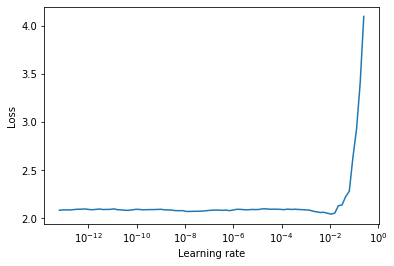

In [11]:
from PIL import Image

# The loss function and optimizer
criterion = torch.nn.CrossEntropyLoss(weight=weights_train) 
optimizer = torch.optim.Adam(net.parameters(), lr=1e-15)

lr_finder = LRFinder(net, optimizer, criterion, device='cuda')
lr_finder.range_test(training_generator, end_lr=1, num_iter=100)
lr_finder.plot()
lr_finder.reset()
del optimizer, criterion, net, lr_finder

In [12]:
net = efficientNet.to(device)
criterion_train = torch.nn.CrossEntropyLoss(weight=weights_train)
criterion_val = torch.nn.CrossEntropyLoss(weight=weights_val)
optimizer = torch.optim.Adam(net.parameters(), lr=4e-6)

Epoch [1/50], Step [500/2729], trainings error: 1.9041, validation error: 1.6496, validation balanced accuracy: 0.4221, saving model: True
Epoch [1/50], Step [1000/2729], trainings error: 1.4981, validation error: 1.3581, validation balanced accuracy: 0.5151, saving model: True
Epoch [1/50], Step [1500/2729], trainings error: 1.2923, validation error: 1.1930, validation balanced accuracy: 0.5838, saving model: True
Epoch [1/50], Step [2000/2729], trainings error: 1.1243, validation error: 1.1237, validation balanced accuracy: 0.6428, saving model: True
Epoch [1/50], Step [2500/2729], trainings error: 1.0479, validation error: 1.0383, validation balanced accuracy: 0.6445, saving model: True
Epoch [2/50], Step [500/2729], trainings error: 0.9141, validation error: 0.9935, validation balanced accuracy: 0.6588, saving model: True
Epoch [2/50], Step [1000/2729], trainings error: 0.8911, validation error: 0.9784, validation balanced accuracy: 0.6635, saving model: True
Epoch [2/50], Step [15

Epoch [12/50], Step [2500/2729], trainings error: 0.5140, validation error: 0.7277, validation balanced accuracy: 0.7617, saving model: True
Epoch [13/50], Step [500/2729], trainings error: 0.5152, validation error: 0.7313, validation balanced accuracy: 0.7632, saving model: False
Epoch [13/50], Step [1000/2729], trainings error: 0.4907, validation error: 0.7542, validation balanced accuracy: 0.7622, saving model: False
Epoch [13/50], Step [1500/2729], trainings error: 0.4921, validation error: 0.7441, validation balanced accuracy: 0.7634, saving model: False
Epoch [13/50], Step [2000/2729], trainings error: 0.4979, validation error: 0.7451, validation balanced accuracy: 0.7625, saving model: False
Epoch [13/50], Step [2500/2729], trainings error: 0.4920, validation error: 0.7440, validation balanced accuracy: 0.7551, saving model: False
Epoch [14/50], Step [500/2729], trainings error: 0.4853, validation error: 0.7652, validation balanced accuracy: 0.7525, saving model: False
Epoch [14

Epoch [24/50], Step [1500/2729], trainings error: 0.3465, validation error: 0.7171, validation balanced accuracy: 0.7760, saving model: False
Epoch [24/50], Step [2000/2729], trainings error: 0.3325, validation error: 0.7173, validation balanced accuracy: 0.7659, saving model: False
Epoch [24/50], Step [2500/2729], trainings error: 0.3436, validation error: 0.7105, validation balanced accuracy: 0.7877, saving model: True
Epoch [25/50], Step [500/2729], trainings error: 0.3414, validation error: 0.7126, validation balanced accuracy: 0.7736, saving model: False
Epoch [25/50], Step [1000/2729], trainings error: 0.3312, validation error: 0.7285, validation balanced accuracy: 0.7668, saving model: False
Epoch [25/50], Step [1500/2729], trainings error: 0.3466, validation error: 0.7211, validation balanced accuracy: 0.7808, saving model: False
Epoch [25/50], Step [2000/2729], trainings error: 0.3301, validation error: 0.7071, validation balanced accuracy: 0.7846, saving model: False
Epoch [2

Epoch [36/50], Step [500/2729], trainings error: 0.2572, validation error: 0.7283, validation balanced accuracy: 0.7870, saving model: False
Epoch [36/50], Step [1000/2729], trainings error: 0.2600, validation error: 0.7021, validation balanced accuracy: 0.7804, saving model: False
Epoch [36/50], Step [1500/2729], trainings error: 0.2712, validation error: 0.7154, validation balanced accuracy: 0.7818, saving model: False
Epoch [36/50], Step [2000/2729], trainings error: 0.2450, validation error: 0.7340, validation balanced accuracy: 0.7886, saving model: False
Epoch [36/50], Step [2500/2729], trainings error: 0.2595, validation error: 0.7350, validation balanced accuracy: 0.7908, saving model: False
Epoch [37/50], Step [500/2729], trainings error: 0.2547, validation error: 0.7176, validation balanced accuracy: 0.7812, saving model: False
Epoch [37/50], Step [1000/2729], trainings error: 0.2553, validation error: 0.6793, validation balanced accuracy: 0.7864, saving model: False
Epoch [3

Epoch [47/50], Step [2000/2729], trainings error: 0.2143, validation error: 0.7344, validation balanced accuracy: 0.7913, saving model: False
Epoch [47/50], Step [2500/2729], trainings error: 0.2253, validation error: 0.7649, validation balanced accuracy: 0.7946, saving model: False
Epoch [48/50], Step [500/2729], trainings error: 0.2224, validation error: 0.7247, validation balanced accuracy: 0.7926, saving model: False
Epoch [48/50], Step [1000/2729], trainings error: 0.2230, validation error: 0.7550, validation balanced accuracy: 0.7863, saving model: False
Epoch [48/50], Step [1500/2729], trainings error: 0.2176, validation error: 0.7098, validation balanced accuracy: 0.7911, saving model: False
Epoch [48/50], Step [2000/2729], trainings error: 0.2188, validation error: 0.7245, validation balanced accuracy: 0.7859, saving model: False
Epoch [48/50], Step [2500/2729], trainings error: 0.2137, validation error: 0.7352, validation balanced accuracy: 0.7904, saving model: False
Epoch [

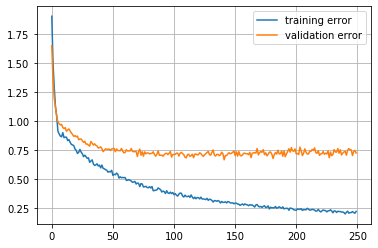

In [13]:
from PIL import Image
from sklearn.metrics import balanced_accuracy_score

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)
max_epochs = 50
accum_grad_epochs = 1

trainings_error = []
validation_error = []
acc_history = []

net.train()
for epoch in range(max_epochs):            
    trainings_error_tmp = []
    
    '''Training EfficientNet'''
    for i, (data_sample, y) in enumerate(training_generator):
        data_gpu = data_sample.to(device)
        y_gpu = y.to(device)
        
        '''Zero the gradients only every 100 iterations for the given epochs'''
        if ((i+1) % 100 == 0) or (epoch+1 > accum_grad_epochs):
            optimizer.zero_grad()
        output = net(data_gpu)
        err = criterion_train(output, y_gpu)
        err.backward()
        optimizer.step()
        trainings_error_tmp.append(err.item())
        
        '''Evaluating loss and accccuracy every 500 iterations'''
        if (i+1) % 500 == 0:     
            mean_trainings_error = np.mean(trainings_error_tmp)
            trainings_error.append(mean_trainings_error)
            trainings_error_tmp = []
            with torch.set_grad_enabled(False):

                validation_error_tmp = []
                y_pred = []
                y_val = []
                net.eval()
                for data_sample, y in validation_generator:
                    data_gpu = data_sample.to(device)
                    y_gpu = y.to(device)
                    output = net(data_gpu)
                    y_pred.extend(list(torch.argmax(output, dim=1).cpu().numpy()))           
                    y_val.extend(list(y.cpu().numpy()))
                    err = criterion_val(output, y_gpu)
                    validation_error_tmp.append(err.item())

                mean_validation_error = np.mean(validation_error_tmp)
                validation_error.append(mean_validation_error)
                bal_acc = balanced_accuracy_score(y_val, y_pred)
                acc_history.append(bal_acc)
                
                '''Save the model with the smallest validation error and the model with the highest balanced accuracy'''
                if mean_validation_error<=min(validation_error):
                    best = net
                    torch.save(best, 'EfficientNet-b3_best_loss.pth')
                    torch.save(best.state_dict(), 'EfficientNet-b3_Parameters_best_loss.pth')
                    save = True
                if bal_acc>=max(acc_history):
                    best = net
                    torch.save(best, 'EfficientNet-b3_best_acc.pth')
                    torch.save(best.state_dict(), 'EfficientNet-b3_Parameters_best_acc.pth')
                    save = True
                print('Epoch [%d/%d], Step [%d/%d], trainings error: %.4f, validation error: %.4f, validation balanced accuracy: %.4f, saving model: %r'
                      %(epoch+1, max_epochs, i+1, len(training_generator), mean_trainings_error, mean_validation_error, bal_acc, save))
                
                save = False
            net.train()
    scheduler.step()
'''Train and validation loss over steps'''
plt.plot(trainings_error, label = 'training error')
plt.plot(validation_error, label = 'validation error')
plt.legend()
plt.grid()
plt.show()

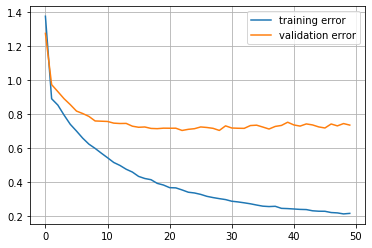

In [14]:
'''Average of every consecutive fiveplex of elements to plot the train and validation loss over epochs'''
trainings_error = np.mean(np.array(trainings_error).reshape(-1, 5), axis=1)
validation_error = np.mean(np.array(validation_error).reshape(-1, 5), axis=1)
plt.plot(trainings_error, label = 'training error')
plt.plot(validation_error, label = 'validation error')
plt.legend()
plt.grid()
plt.show()

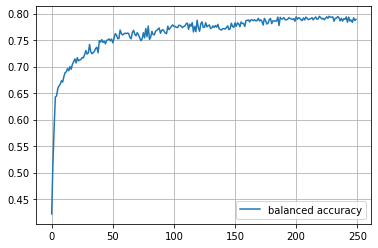

In [15]:
'''Balanced Accuracy'''
plt.plot(acc_history, label = 'balanced accuracy')
plt.legend()
plt.grid()
plt.show()

In [41]:
'''Loading model with best loss'''
best = torch.load('C:/Users/desktop-pc/Desktop/EfficientNet-b3/EfficientNet-b3_best_loss.pth')

In [42]:
'''Evaluating on test set'''
best.eval()
test_set = Dataset(test_df, transform=composed_test)
test_generator = data.SequentialSampler(test_set)
y_pred = []
y_true = []
for i in test_generator:
    data_sample, y = test_set.__getitem__(i)
    data_gpu = data_sample.unsqueeze(0).to(device)
    output = best(data_gpu)
    result = torch.argmax(output)
    y_pred.append(result.item())
    y_true.append(y.item())

correct_results = np.array(y_pred)==np.array(y_true)
sum_correct = np.sum(correct_results)
accuracy = sum_correct/test_generator.__len__()

In [43]:
from sklearn.metrics import balanced_accuracy_score, recall_score, classification_report, confusion_matrix

# Accuracy, Balanced Accuracy and Recall Scores
balanced_acc = balanced_accuracy_score(y_true, y_pred)
recall_score_macro = recall_score(y_true, y_pred, average='macro') 
recall_score_micro = recall_score(y_true, y_pred, average='micro')
recall_score = recall_score(y_true, y_pred, average=None) 

print("Accuracy ", accuracy)
print("Balanced Accuracy ", balanced_acc)
print("Recall Score macro ", recall_score_macro)
print("Recall Score micro ", recall_score_micro)
print("Recall Score for each class ", recall_score)

Accuracy  0.7947098302408212
Balanced Accuracy  0.7951678252311716
Recall Score macro  0.7951678252311716
Recall Score micro  0.7947098302408212
Recall Score for each class  [0.64367816 0.84355828 0.72202166 0.70190275 0.84118117 1.
 0.93103448 0.6779661 ]


In [44]:
target_names = ['AK actinic keratosis', 'BCC basal cell carcinoma', 'BKL benign keratosis', 'MEL melanoma', 'NV Melanocytic nevi', 'VASC vascular lesion', 'DF dermatofibroma ', 'SCC Squamous cell carcinoma']
print(classification_report(y_true, y_pred, target_names=target_names))

                             precision    recall  f1-score   support

       AK actinic keratosis       0.46      0.64      0.53        87
   BCC basal cell carcinoma       0.80      0.84      0.82       326
       BKL benign keratosis       0.68      0.72      0.70       277
               MEL melanoma       0.72      0.70      0.71       473
        NV Melanocytic nevi       0.92      0.84      0.88      1253
       VASC vascular lesion       0.72      1.00      0.84        29
         DF dermatofibroma        0.57      0.93      0.71        29
SCC Squamous cell carcinoma       0.53      0.68      0.60        59

                   accuracy                           0.79      2533
                  macro avg       0.68      0.80      0.72      2533
               weighted avg       0.81      0.79      0.80      2533



In [45]:
# https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py
cnf_matrix = confusion_matrix(y_true, y_pred)
print(cnf_matrix)

[[  56   10   13    0    0    0    2    6]
 [  19  275   10    6    5    0    2    9]
 [  23    7  200   18   17    0    3    9]
 [  14   21   20  332   74    2    3    7]
 [   6   24   43  105 1054    9    9    3]
 [   0    0    0    0    0   29    0    0]
 [   0    1    0    0    0    0   27    1]
 [   5    4    6    2    1    0    1   40]]


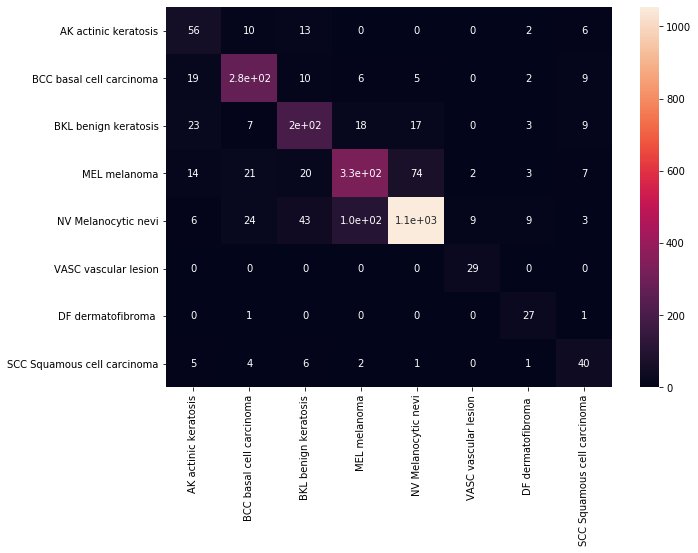

In [46]:
import seaborn as sn
# Ploting the Confusion Matrix
df_cm = pd.DataFrame(cnf_matrix, index = target_names, columns = target_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [47]:
lesion_type_dict = {0:'AK actinic keratosis', 1:'BCC basal cell carcinoma', 2:'BKL benign keratosis', 3: 'MEL melanoma', 4: 'NV Melanocytic nevi', 5: 'VASC vascular lesion', 6: 'DF dermatofibroma ', 7: 'SCC Squamous cell carcinoma'}
for condition in range(8):
    print(lesion_type_dict[condition])

AK actinic keratosis
BCC basal cell carcinoma
BKL benign keratosis
MEL melanoma
NV Melanocytic nevi
VASC vascular lesion
DF dermatofibroma 
SCC Squamous cell carcinoma


In [48]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)
# Multiclass Roc-AUC Score
multiclass_roc_auc_score(y_true, y_pred)

0.8810570027078113